In [3]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tensorflow.keras.layers import Dense , Dropout
from scikeras.wrappers import KerasRegressor 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV


In [4]:
#data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/TPath_300_finish_data.pkl')
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/Finish_D2_I7000_F9000/TPath_500_finish_data_D2.pkl')

data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.0000,-0.00200,500,7000,9000,669.05
1,0.0000,-0.00198,500,7000,9000,682.81
2,0.0000,-0.00196,500,7000,9000,696.80
3,0.0000,-0.00194,500,7000,9000,710.67
4,0.0000,-0.00192,500,7000,9000,724.42
...,...,...,...,...,...,...
25321,0.0025,0.00192,500,7000,9000,584.84
25322,0.0025,0.00194,500,7000,9000,581.64
25323,0.0025,0.00196,500,7000,9000,578.47
25324,0.0025,0.00198,500,7000,9000,575.32


In [5]:
df = data.drop(data.columns[2:5], axis = 1)
df

,X-Koordinate,Y-Koordinate,Temperatur
0,0.0000,-0.00200,669.05
1,0.0000,-0.00198,682.81
2,0.0000,-0.00196,696.80
3,0.0000,-0.00194,710.67
4,0.0000,-0.00192,724.42
...,...,...,...
25321,0.0025,0.00192,584.84
25322,0.0025,0.00194,581.64
25323,0.0025,0.00196,578.47
25324,0.0025,0.00198,575.32


In [6]:
df1 = df.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen

print(df1)
df_reset = df1.reset_index(drop=True)
df_reset

       X-Koordinate  Y-Koordinate  Temperatur
5099        0.00050      -0.00052     1471.00
12799       0.00126       0.00072     1319.30
15071       0.00148       0.00194      595.19
24620       0.00244      -0.00004     1249.00
11071       0.00110      -0.00168      884.35
...             ...           ...         ...
21575       0.00214      -0.00064     1263.60
5390        0.00052       0.00128     1035.40
860         0.00008      -0.00088     1376.50
15795       0.00156       0.00034     1383.80
23654       0.00234       0.00074     1149.60

[25326 rows x 3 columns]


,X-Koordinate,Y-Koordinate,Temperatur
0,0.00050,-0.00052,1471.00
1,0.00126,0.00072,1319.30
2,0.00148,0.00194,595.19
3,0.00244,-0.00004,1249.00
4,0.00110,-0.00168,884.35
...,...,...,...
25321,0.00214,-0.00064,1263.60
25322,0.00052,0.00128,1035.40
25323,0.00008,-0.00088,1376.50
25324,0.00156,0.00034,1383.80


In [7]:
label = df_reset["Temperatur"]
# Korrektur: Verwenden Sie den Spaltennamen direkt, ohne Indexierung der columns-Eigenschaft
df1 = df_reset.drop("Temperatur", axis=1)
X = df1
y = label


In [8]:
X

,X-Koordinate,Y-Koordinate
0,0.00050,-0.00052
1,0.00126,0.00072
2,0.00148,0.00194
3,0.00244,-0.00004
4,0.00110,-0.00168
...,...,...
25321,0.00214,-0.00064
25322,0.00052,0.00128
25323,0.00008,-0.00088
25324,0.00156,0.00034


In [9]:
y

0        1471.00
1        1319.30
2         595.19
3        1249.00
4         884.35
          ...   
25321    1263.60
25322    1035.40
25323    1376.50
25324    1383.80
25325    1149.60
Name: Temperatur, Length: 25326, dtype: float64

In [10]:
 # train_df enthält 80% der Daten, test_df enthält 20% der Daten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [11]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
scaler_features2 = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)  # Nutze unterschiedliche Skalierungsparameter

# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel, wenn nötig
scaler_target = MinMaxScaler()


# Skaliere y_train und y_test. Beachte, dass y_train.reshape(-1, 1) verwendet wird, da MinMaxScaler 
# erwartet, dass die Eingaben als 2D-Arrays kommen, und Ziele normalerweise als 1D-Arrays vorliegen.
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))


In [12]:
X_train_scaled

array([[1.   , 0.15 ],
       [0.984, 0.49 ],
       [0.224, 0.905],
       ...,
       [0.04 , 0.585],
       [0.976, 0.815],
       [0.744, 0.785]])

# Netzwerkarchitektur

In [13]:
# Netzwerkarchitektur
model = Sequential([

    Dense(136, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(216, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(104, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(328, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(8, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(120, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    #Dense(216, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Trainingsparameter
batch_size = 150
epochs = 200

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/200
109/109 [==============================] - 2s 5ms/step - loss: 0.2601 - mae: 0.2663 - val_loss: 0.1557 - val_mae: 0.1538
Epoch 2/200
109/109 [==============================] - 0s 3ms/step - loss: 0.1205 - mae: 0.0804 - val_loss: 0.1037 - val_mae: 0.0556
Epoch 3/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0954 - mae: 0.0285 - val_loss: 0.0931 - val_mae: 0.0444
Epoch 4/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0883 - mae: 0.0293 - val_loss: 0.0839 - val_mae: 0.0156
Epoch 5/200
109/109 [==============================] - 0s 2ms/step - loss: 0.0813 - mae: 0.0138 - val_loss: 0.0797 - val_mae: 0.0274
Epoch 6/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0766 - mae: 0.0135 - val_loss: 0.0742 - val_mae: 0.0075
Epoch 7/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0730 - mae: 0.0190 - val_loss: 0.0799 - val_mae: 0.0675
Epoch 8/200
109/109 [==============================] - 0s 3ms/step - 

In [14]:
results = model.evaluate(X_test_scaled, y_test_scaled, verbose=2)
results

159/159 - 0s - loss: 9.6141e-04 - mae: 0.0036 - 207ms/epoch - 1ms/step


[0.0009614102891646326, 0.0036498280242085457]

In [15]:
scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[100]} Actual: {original_actual_values[100]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")

    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]

    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)

    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")


 Bsp. Predicted: [1282.1337] Actual: [1286.9] 
Durchschnittliche Abweichung (MAE): [3.45931179]


In [16]:
def calculate_r_squared(predicted, actual):
    # Berechnung des Mittelwerts der tatsächlichen Werte
    mean_actual = sum(actual) / len(actual)
    
    # Berechnung der totalen Summe der Quadrate (SST)
    sst = sum((x - mean_actual) ** 2 for x in actual)
    
    # Berechnung der Summe der Quadrate der Residuen (SSE)
    sse = sum((actual[i] - predicted[i]) ** 2 for i in range(len(actual)))
    
    # Berechnung des R^2-Wertes
    r_squared = 1 - (sse / sst)
    
    return r_squared

# Berechnung von R^2 mit den bereitgestellten Listen
r_squared = calculate_r_squared(list1, list2)

print(f"R^2: {r_squared}")

R^2: [0.99966686]


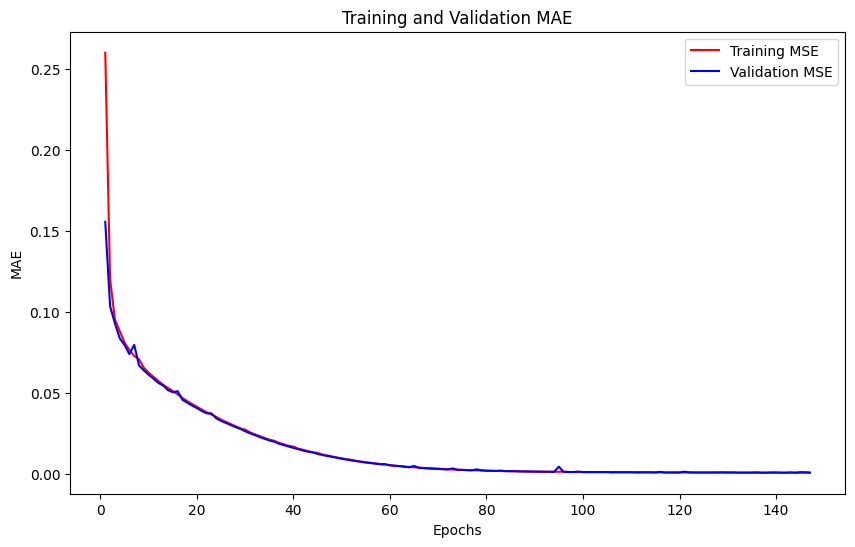

In [17]:
mae = history.history['loss']
val_mae = history.history['val_loss']

epochs = range(1, len(mae) + 1)

# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'r', label='Training MSE')
plt.plot(epochs, val_mae, 'b', label='Validation MSE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [18]:
df_result = pd.DataFrame({'Echt': [val[0] for val in list1], 'Vorhergesagt': [val[0] for val in list2]})
df_result['X-Koordinate'] = X_test_scaled[:, 0]
df_result['Y-Koordinate'] = X_test_scaled[:, 1]

df_result['Differenz'] = df_result['Echt'] - df_result['Vorhergesagt']
df_result['Differenz'].sort_values()
sorted_df = df_result.sort_values(by= 'Differenz')
Anzahl_Punkte = (sorted_df['Differenz'] > -10).sum()
print("Anzahl der Werte die kleiner sind:", Anzahl_Punkte)

sorted_df

Anzahl der Werte die kleiner sind: 4902


,Echt,Vorhergesagt,X-Koordinate,Y-Koordinate,Differenz
2493,803.836792,836.38,0.992,0.900,-32.543208
2316,724.888916,755.11,0.992,0.930,-30.221084
2187,764.312805,793.93,0.976,0.915,-29.617195
2696,790.613831,820.06,0.976,0.905,-29.446169
914,803.764099,832.31,0.976,0.900,-28.545901
...,...,...,...,...,...
4512,592.893677,575.70,0.992,0.995,17.193677
1631,680.440369,663.16,0.888,0.000,17.280369
1682,592.893677,574.64,0.960,1.000,18.253677
3759,592.893677,573.83,0.976,1.000,19.063677


# GridSearch

In [19]:
# def build_model(learning_rate=0.001, activation='relu', regularization=0.0001, dropout_rate=0.0):
#     model = Sequential()
#     model.add(Dense(264, activation=activation, input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(168, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(88, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(264, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(200, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     # model.add(Dense(192, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     # model.add(Dropout(dropout_rate))
#     # 
#     # model.add(Dense(32, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     # model.add(Dropout(dropout_rate))
#     # 
#     # model.add(Dense(448, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     # model.add(Dropout(dropout_rate))    
#     # 
#     # model.add(Dense(64, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     # model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
#     return model
# 
# # Verwenden Sie eine Funktion, um das Modell zu instanziieren, für scikit-learn Wrapper
# model = KerasRegressor(model=build_model, verbose=2)
# 
# # Anpassung der Parameter im param_grid
# param_grid = {
#     'model__learning_rate': [0.01, 0.001, 0.0001],
#     'model__regularization': [0.001, 0.0001],
#     'fit__batch_size': [50, 100, 150, 200],
#     'fit__epochs': [50],
#     'model__dropout_rate' : [0.0, 0.1, 0.2]
# }
# 
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
# # Hinweis: Stellen Sie sicher, dass Ihre Daten (X_train_scaled, y_train_scaled) korrekt definiert sind
# grid_result = grid_search.fit(X_train_scaled, y_train_scaled)
# # Beste Parameter und Score ausgeben
# print("Beste Parameter:", grid_search.best_params_)
# print("Beste Genauigkeit:", grid_search.best_score_)
# 
# with open("Gridsearch_D2_1.txt", "w") as f:
#     f.write(f"Beste Parameter: {grid_search.best_params_}\n")
#     f.write(f"Beste Genauigkeit: {grid_search.best_score_}")


# Random Search Architektur

In [20]:
# # Funktion zum Erstellen des Modells
# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(hp.Int('input_units', min_value=8, max_value=328, step=16), input_shape=(2,), activation='relu'))
#     for i in range(hp.Int('n_layers', 1, 10)):
#         model.add(Dense(hp.Int(f'units_{i}', min_value=8, max_value=328, step=16), activation='relu'))
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model
# 
# # Durchführung der Random Search dreimal
# for run in range(1, 4):
#     # Anpassen des Verzeichnisses und des Projektnamens für jeden Durchlauf
#     directory = 'random_search'
#     project_name = f'random_search_D2_{run}'
#     
#     tuner = RandomSearch(
#         build_model,
#         objective='val_loss',
#         max_trials=100,
#         executions_per_trial=1,
#         directory=directory,
#         project_name=project_name
#     )
#     
#     # Durchführung des Random Search
#     tuner.search(X_train_scaled, y_train_scaled, epochs=200, verbose =0, batch_size=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
#     
#     # Abrufen und Speichern des besten Modells
#     best_model = tuner.get_best_models(num_models=1)[0]
#     model_path = os.path.join(directory, project_name, 'best_model.h5') 
#     best_model.save(model_path)
#     
# 
#     # Optional: Abrufen und Ausgeben der besten Hyperparameter
#     best_hyperparameters = tuner.get_best_hyperparameters()[0]
#     
#     # Konvertieren der Hyperparameter in ein DataFrame
#     df_hyperparameters = pd.DataFrame([best_hyperparameters.values])
#     # Speichern des DataFrame als CSV
#     df_hyperparameters.to_csv(f'random_search_D2_{run}.csv', index=False)
#     
#     print(f"Beste Hyperparameter für Lauf {run}: {best_hyperparameters.values}")